# 102 - Veri mühendisliği - y'de bias ve scale

[101](https://github.com/azmesai/suni-dimag/blob/master/101/101.ipynb) dersinde kurduğumuz ağ üzerinden, verimizdeki hedef değerlerin (y) bazı özelliklerinin ağımızın performansını nasıl etkilediğini inceleyeceğiz.


In [1]:
%matplotlib inline
from keras.layers import Dense
from keras.models import Sequential
import random
import matplotlib.pyplot as plt
import math
import numpy as np

np.random.seed(1337)

Using TensorFlow backend.


## Training ve test kümelerinin oluşturulması

Önceki derste yazdığımız training ve test kümelerini üreten fonksiyonları biraz daha genelleştirdik. Bu kez parametre olarak bir fonksiyon alıyorlar ve y değerlerini, ürettikleri X değerlerini bu fonksiyondan geçirerek oluşturuyorlar. 

Yeni yazdığımız sine_function fonksiyonu ise bize üç ayrı ayarlanabilir parametresi olan bir sinüs fonksiyonu döndürüyor. Training ve test kümesi üreten fonksiyonlara parametre olaran buradan aldığımız fonksiyonu geçeceğiz.

testModel fonksiyonu ise yine geçen derste kullandığımız grafik fonksiyonunun aynısı.

In [2]:
def sine_function(noiserate=0, bias=0, scale=1):
    def _sine_function(angle):
        return (math.sin(angle)+random.uniform(-noiserate,noiserate))*scale+bias
    return _sine_function

def trainingData(func):
    noiserate = 0.2
    X = []
    y = []
    for i in range(0,600):
        angle=random.uniform(-math.pi,math.pi)
        X.append(angle)
        y.append(func(angle))
    return X,y

def testData(func):
    X = []
    y = []
    for i in range(-1800,1800):
        angle = math.radians(i/10)
        X.append(angle)
        y.append(func(angle))
    return X,y

def testModel(X,y):
    res = model.predict(X, batch_size=32)

    plt.plot(X,y, label='sin')
    plt.plot(X,res, label='sonuc')
    plt.xlabel('x (Radyan)')
    plt.ylabel('sin(x)')
    plt.legend()
    plt.show()

## Modelin oluşturulması

Yine bir önceki derste kullandığımız modelin aynısını kullanacağız.

Modelimizi oluşturduktan sonra tüm bağlantı ağırlıklarını bir değişkende saklıyoruz ki her deneye aynı noktadan başlayabilelim.

In [3]:
model = Sequential()
model.add(Dense(80, input_shape=(1,), activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='sgd')

weights = model.get_weights()

## Deney 0 - Referans

İlk olarak *noiserate* = 0, *bias* = 0 ve *scale* = 1 ile ağımızı 450 *epoch* eğittizde nasıl bir sonuç aldığımıza bakalım. Bu bizim referansımız olacak. Yapacağımız değişikliklerde performansı bu referanslar karşılastıracağız.

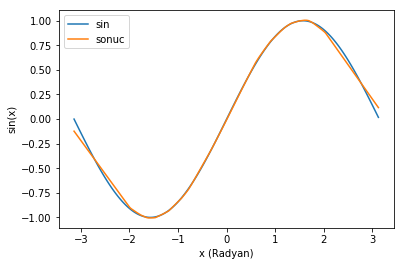

In [4]:
model.set_weights(weights)
sine = sine_function(noiserate=0,bias=0,scale=1)
X,y = trainingData(sine)
X_test, y_test = testData(sine)

model.fit(X, y, epochs=350,verbose=0)
testModel(X_test,y_test)

### Bakalım *bias* neyi değiştiriyor.

## Deney 1 - Pozitif Bias

Fonskiyonumuzun *bias* ayarı, fonksiyonun çıktısını olduğu gibi yukarı veya aşağı itelemeye yarıyor. Yukarıdaki örnekte sinüs fonksiyonunun -1 ile 1 arası değerler döndüğünü görüyorsunuz. Şimdi aynı fonksiyonu 39 ile 41 arası değerler dönecek halde tanımlayıp ağımızı yeniden eğitmeyi deneyelim.

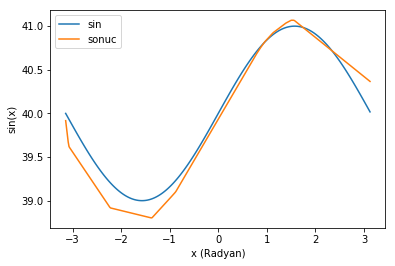

In [5]:
model.set_weights(weights)
sine = sine_function(noiserate=0,bias=40,scale=1)
X,y = trainingData(sine)
X_test, y_test = testData(sine)

model.compile(loss='mse', optimizer='sgd')
model.fit(X, y, epochs=350, verbose=0)
testModel(X_test,y_test)

Ağımızın performansı gözle görülür ölçüde düştü. Konuyu iyice abartırsak ne olur dersiniz?

In [6]:
model.set_weights(weights)
sine = sine_function(noiserate=0,bias=400,scale=1)
X,y = trainingData(sine)
X_test, y_test = testData(sine)

model.compile(loss='mse', optimizer='sgd')
model.fit(X, y, epochs=3)

Epoch 1/3
600/600 [==============================] - 0s - loss: nan             
Epoch 2/3
600/600 [==============================] - 0s - loss: nan     
Epoch 3/3
600/600 [==============================] - 0s - loss: nan     


*Loss* taşma yapacak derece büyüdü ve modelin hesaplayamayacağı hale geldi.

## Deney 2 - Küçük scale

Fonskiyonumuzun *scale* ayarı, fonksiyonun çıktısını y ekseninde daraltıp genişletmeye yarıyor. Yukarıdaki örnekte sinüs fonksiyonunun -1 ile 1 arası değerler döndüğünü görüyorsunuz. Şimdi aynı fonksiyonu -0.1 ile 0.1 arası değerler dönecek halde tanımlayıp ağımızı yeniden eğitmeyi deneyelim.

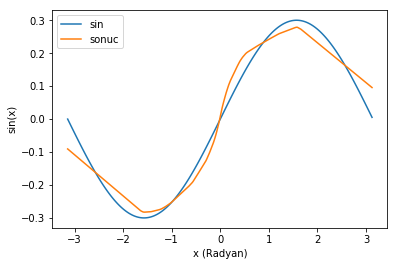

In [7]:
model.set_weights(weights)
sine = sine_function(noiserate=0,bias=0,scale=0.3)
X,y = trainingData(sine)
X_test, y_test = testData(sine)

model.compile(loss='mse', optimizer='sgd')
model.fit(X, y, epochs=350, verbose=0)
testModel(X_test,y_test)

Ağımızın performansı yine düştü. Fakat bu seferki çıktı önceki derste ağımız fonksiyonu tam olarak öğrenemeden arada çizdiğimiz grafiklere benziyor. Eğitimi biraz daha sürdürelim.

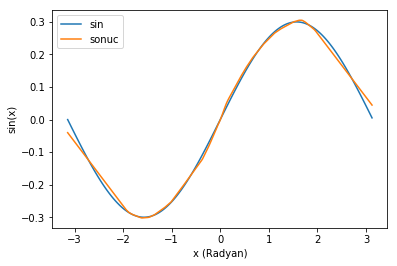

In [8]:
model.fit(X, y, epochs=600, verbose=0)
testModel(X_test,y_test)

Evet gerçekten de öğrenmeyi başardı, ama eğitim neredeyse 3 kat uzun sürdü ve hala performansımız referans kadar iyi değil.

Uuuu beybi.

## Özet

- Ağımıza öğretmeye çalıştığımız hedef değerlerin *bias* ve *scale*'i veya istatistik diliyle ortalama ve varyans'ı önemli. Seçilen aktivasyon fonksiyolanlarına göre kullanılabilecek aralıklar değişse bile, ortalamanın 0, varyansın ise 1 olduğu durum genellikle tercih edilir.
- Yüksek *bias*, veya ortalamanın yüksek olması nöronların hassasiyetlerini yitirmesi ve aşırı durumlarda ağırlık veya *loss* değerinin taşma yapmasına sebep olabilir.
- Küçük scale veya varyansın düşük olması durumunda nöronlar hem hassasiyetlerini kaybeder, hem de eğitim çok daha uzun sürer.

## Ödevler

- Negatif *bias* durumunda ağın performansı nasıl etkileniyor?
- *Scale*'in gereğinden büyük olması durumunda ağın performansı nasıl etkileniyor?
- Aynı deneyleri gürültü miktarını 0.2 olarak ayarlayıp tekrarlayın. Bu durumda ne değişiyor?